## Ito current
***Written by: Akwasi Darkwah Akwaboah***<br>
***19/01/2020***

Cordeiro et al adjustment: $V_{1/2} = -41.1\pm 0.2mV$, $k = 6.68\pm 0.19$

***Implement Voltage clamp protocol***

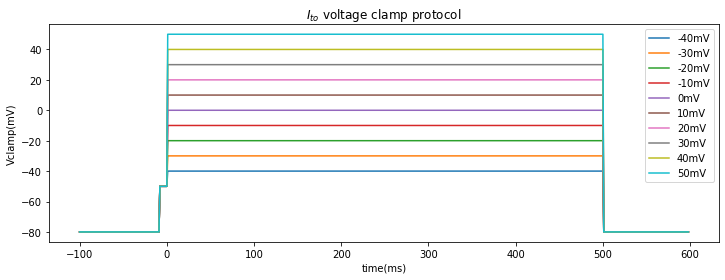

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Vcm = np.arange(-40, 51, 10)    # mV, Command Voltage
Vh_pre = -80    # mV,prepulse Holding Voltage
Vh_brief = -50 #mV
Vh_post = -80   # mV post holding
dt = 1  # time step
tStart = -100
tEnd = 600
nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
Vm = np.zeros((nStep + 1, 1), dtype=np.float)
plot_time = np.empty((nStep, 1), dtype=np.float)
plot_Vm = np.empty((nStep, len(Vcm)), dtype=np.float)
t = np.linspace(tStart, tEnd, nStep + 1)
i = 0  #column selector

for Vc in Vcm:
    tNow = tStart
    Vm[0] = Vh_pre
    for iStep in np.arange(nStep):
            Vm[iStep+1] = (-10 < tNow < 0.0)* Vh_brief + (tNow <= -10)*Vh_pre + (0.0 <= tNow < 500.0) * Vc +  (tNow >= 500.0) * Vh_post
            plot_Vm[iStep, i] = Vm[iStep]
            plot_time[iStep] = tNow
            tNow = tStart + iStep * dt
    i = i + 1 #increment to next clamp column

plt.figure(figsize = (12,4))
plt.plot(plot_time, plot_Vm)
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{to}$ voltage clamp protocol')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')

#plt.grid()
plt.show()

***Ito function call - long and short zoomed time course - iniital model w/ cordeiro et al. adjustment***

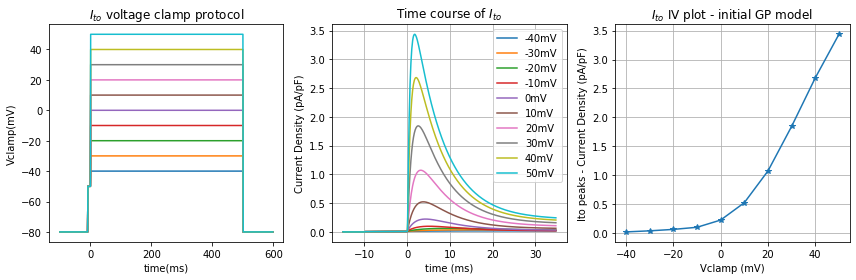

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

timer_start = timeit.default_timer()

def Ito_func(Gtof, Gtos, xtoss_a, xtoss_b, tx_af, tx_bf, tx_cf, tx_df, ty_af, ty_bf, ty_cf, ty_df,
             tx_as, tx_bs, tx_cs, tx_ds, ty_as, ty_bs, ty_cs, ty_ds):
    
    
    Vcm = np.arange(-40, 51, 10)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_brief = -50 #mV
    Vh_post = -80   # mV post holding
    dt = 0.1  # time step
    tStart = -15
    tEnd = 600.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables
    
    #xtos = 0.044245060085 #initial condition

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    
    plot_xtof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_xtos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_tau_xf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_yf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_xs = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_ys = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_Ito = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        # initial condition
        xtof = 0.001329874225
        ytof = 0.947695521609
        xtos = 0.004100000000
        ytos = 0.994600000000

        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (-10 < tNow < 0.0)* Vh_brief + (tNow <= -10)*Vh_pre + (0.0 <= tNow < 500.0) * Vc +  (tNow >= 500.0) * Vh_post
            xtoss = 1 / (1 + np.exp(-(Vm[iStep] - xtoss_a) / xtoss_b))
            ytoss = 1 / (1 + np.exp((Vm[iStep] + 41.1) / 6.68))
            
            #fast Ito
            tau_xf = tx_af*(np.exp(-((Vm[iStep]+tx_bf)/tx_cf)**2)) + tx_df
            tau_yf = ty_af*(np.exp(-((Vm[iStep]+ty_bf)**2)/ty_cf)) + ty_df
            dxtof = ((xtoss - xtof)/ tau_xf)*dt
            dytof = ((ytoss - ytof)/ tau_yf)*dt
            Itof = Gtof * xtof * ytof * (Vm[iStep] - EK)
            
            #slow Ito
            tau_xs = tx_as/(1+np.exp((Vm[iStep]+tx_bs)/tx_cs)) + tx_ds
            tau_ys = ty_as/(1+np.exp((Vm[iStep]+ty_bs)/ty_cs)) + ty_ds
            dxtos = ((xtoss - xtos)/ tau_xs)*dt
            dytos = ((ytoss - ytos)/ tau_ys)*dt
            Itos = Gtos * xtos * ytos * (Vm[iStep] - EK)
            
            Ito = Itof + Itos
            
            Im = Ito + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xtof[iStep, i] = xtof
            plot_ytof[iStep, i] = ytof
            plot_tau_xf[iStep, i] = tau_xf
            plot_tau_yf[iStep, i] = tau_yf
            plot_tau_xs[iStep, i] = tau_xs
            plot_tau_ys[iStep, i] = tau_ys
            plot_Ito[iStep, i] = Ito
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xtof = xtof+dxtof
            ytof = ytof+dytof
            xtos = xtos+dxtos
            ytos = ytos+dytos
            
            tNow = tStart + iStep * dt
        i = i + 1
#     timer_stop = timeit.default_timer()
#     print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
    Ito_peaks = np.max(plot_Ito, axis=0)
    # plt.figure()
    # plt.plot(Vcm, Ito_peaks, '-*', Vcm, Ito_exp, '-o')
    # plt.legend(['model', 'exp'])
    # plt.show()
    return Ito_peaks, plot_time, plot_Ito
    #return Ito_peaks


Ito, time, plot_Ito = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)
Vcm = np.arange(-40, 51, 10)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(plot_time, plot_Vm)
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{to}$ voltage clamp protocol')
#plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')

plt.subplot(1,3,3)
plt.plot(Vcm, Ito, '-*')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Ito peaks - Current Density (pA/pF)')
plt.title('$I_{to}$ IV plot - initial GP model')
plt.grid()
#plt.show()

# plt.figure(figsize=(6.5,5))
# plt.plot(time, plot_Ito)
# plt.xlabel('time (ms)')
# plt.ylabel('Current Density (pA/pF)')
# plt.title('Time course of $I_{to}$')
# plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
# plt.grid()
# plt.show()

plt.subplot(1,3,2)
plt.plot(time[:500], plot_Ito[:500])
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.tight_layout()
plt.show()


***Ito func for GA- reduced computational runtime, tEnd = 25ms***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

timer_start = timeit.default_timer()

def Ito_func(Gtof, Gtos, xtoss_a, xtoss_b, tx_af, tx_bf, tx_cf, tx_df, ty_af, ty_bf, ty_cf, ty_df,
             tx_as, tx_bs, tx_cs, tx_ds, ty_as, ty_bs, ty_cs, ty_ds):
    
    
    Vcm = np.arange(-40, 51, 10)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_brief = -50 #mV
    Vh_post = -80   # mV post holding
    dt = 0.1  # time step
    tStart = -15
    tEnd = 25.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables
    
    #xtos = 0.044245060085 #initial condition

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    
    plot_xtof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytof = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_xtos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_ytos = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_tau_xf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_yf = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_xs = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tau_ys = np.zeros((nStep, len(Vcm)), dtype=np.float)
    
    plot_Ito = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        # initial condition
        xtof = 0.001329874225
        ytof = 0.947695521609
        xtos = 0.004100000000
        ytos = 0.994600000000

        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (-10 < tNow < 0.0)* Vh_brief + (tNow <= -10)*Vh_pre + (0.0 <= tNow < 500.0) * Vc +  (tNow >= 500.0) * Vh_post
            xtoss = 1 / (1 + np.exp(-(Vm[iStep] - xtoss_a) / xtoss_b))
            ytoss = 1 / (1 + np.exp((Vm[iStep] + 41.1) / 6.68))
            
            #fast Ito
            tau_xf = tx_af*(np.exp(-((Vm[iStep]+tx_bf)/tx_cf)**2)) + tx_df
            tau_yf = ty_af*(np.exp(-((Vm[iStep]+ty_bf)**2)/ty_cf)) + ty_df
            dxtof = ((xtoss - xtof)/ tau_xf)*dt
            dytof = ((ytoss - ytof)/ tau_yf)*dt
            Itof = Gtof * xtof * ytof * (Vm[iStep] - EK)
            
            #slow Ito
            tau_xs = tx_as/(1+np.exp((Vm[iStep]+tx_bs)/tx_cs)) + tx_ds
            tau_ys = ty_as/(1+np.exp((Vm[iStep]+ty_bs)/ty_cs)) + ty_ds
            dxtos = ((xtoss - xtos)/ tau_xs)*dt
            dytos = ((ytoss - ytos)/ tau_ys)*dt
            Itos = Gtos * xtos * ytos * (Vm[iStep] - EK)
            
            Ito = Itof + Itos
            
            Im = Ito + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xtof[iStep, i] = xtof
            plot_ytof[iStep, i] = ytof
            plot_tau_xf[iStep, i] = tau_xf
            plot_tau_yf[iStep, i] = tau_yf
            plot_tau_xs[iStep, i] = tau_xs
            plot_tau_ys[iStep, i] = tau_ys
            plot_Ito[iStep, i] = Ito
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xtof = xtof+dxtof
            ytof = ytof+dytof
            xtos = xtos+dxtos
            ytos = ytos+dytos
            
            tNow = tStart + iStep * dt
        i = i + 1
#     timer_stop = timeit.default_timer()
#     print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
    Ito_peaks = np.max(plot_Ito, axis=0)
    # plt.figure()
    # plt.plot(Vcm, Ito_peaks, '-*', Vcm, Ito_exp, '-o')
    # plt.legend(['model', 'exp'])
    # plt.show()
    return Ito_peaks, plot_time, plot_Ito
    #return Ito_peaks


In [4]:
# Creating a class to hold the trials data
import pickle

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    
trial1 = GA_trial()
trial1.loss = np.arange(1,10,2)
trial1.fitness = 3
print(trial1.loss)

pickle.dump(trial1, open('trial_save.p', 'wb'))
C = pickle.load(open('trial_save.p', 'rb'))
print(C.loss)

[1 3 5 7 9]
[1 3 5 7 9]


**GA 1**

generation:  0
Runtime:  1.0270550066666602 mins
fitness:  4.19125879055628
generation:  5
Runtime:  5.462206288333346 mins
fitness:  0.5131769126124601
generation:  10
Runtime:  9.686978974999995 mins
fitness:  0.3022419625351291
generation:  15
Runtime:  13.897070803333342 mins
fitness:  0.27918840532179034
generation:  20
Runtime:  18.289132013333315 mins
fitness:  0.2699845468047618
generation:  25
Runtime:  22.557540981666655 mins
fitness:  0.2563111188867486
generation:  30
Runtime:  26.967750835 mins
fitness:  0.24545532019576255
generation:  35
Runtime:  31.526705906666667 mins
fitness:  0.2335835284088839
generation:  40
Runtime:  36.106442391666675 mins
fitness:  0.22598757497723934
generation:  45
Runtime:  40.61047248333334 mins
fitness:  0.21753290743939024
generation:  50
Runtime:  45.114887071666665 mins
fitness:  0.21288667624873836
generation:  55
Runtime:  49.61692094999999 mins
fitness:  0.20968418623119334
generation:  60
Runtime:  54.120743736666675 mins
fitness:  

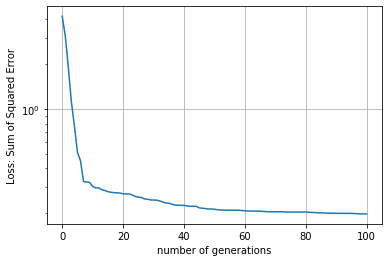

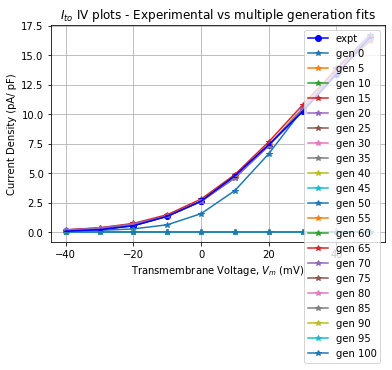

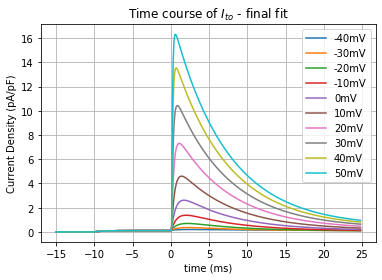

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 51, 10)    # mV, Command Voltage

# actual Y
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

# Population
# Parameter initialization
C = np.empty((200, 20))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #gtof
C[:, 1] = np.random.uniform(0, 0.1, C.shape[0])     #gtos

C[:, 2] = np.random.uniform(15.0, 25.0, C.shape[0]) #xa
C[:, 3] = np.random.uniform(8, 15, C.shape[0])     #xb
C[:, 4] = np.random.uniform(3.5, 12.5, C.shape[0])         #txaf
C[:, 5] = np.random.uniform(40, 50, C.shape[0])      #txbf
C[:, 6] = np.random.uniform(40, 60, C.shape[0])         #txcf
C[:, 7] = np.random.uniform(0, 2, C.shape[0])      #txdf
C[:, 8] = np.random.uniform(70, 95, C.shape[0])         #tyaf
C[:, 9] = np.random.uniform(30, 50, C.shape[0])       #tybf
C[:, 10] = np.random.uniform(200, 250, C.shape[0])         #tycf
C[:, 11] = np.random.uniform(5, 10, C.shape[0])          #tydf

C[:, 12] = np.random.uniform(7, 11, C.shape[0])         #txas
C[:, 13] = np.random.uniform(1, 5, C.shape[0])      #txbs
C[:, 14] = np.random.uniform(13, 17, C.shape[0])         #txcs
C[:, 15] = np.random.uniform(0, 1, C.shape[0])      #txds
C[:, 16] = np.random.uniform(750, 850, C.shape[0])         #tyas
C[:, 17] = np.random.uniform(50, 70, C.shape[0])       #tybs
C[:, 18] = np.random.uniform(8, 12, C.shape[0])         #tycs
C[:, 19] = np.random.uniform(25, 35, C.shape[0])          #tyds


##population = np.transpose(C)

Ito = np.empty((C.shape[0], len(V)))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ito[i,:], time, plt_Ito = Ito_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12],  ppln[i, 13], ppln[i, 14],
                                 ppln[i, 15], ppln[i, 16], ppln[i, 17], ppln[i, 18], ppln[i, 19])
    SSE = np.sum((Ito - Ito_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gtof
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +    #gtos
                        
                         (gene_select == 2)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 3)*np.random.uniform(-1.5, 1.5) +          #xb

                         (gene_select == 4)*np.random.uniform(-1.5, 1.5) +          #txaf
                         (gene_select == 5)*np.random.uniform(-5.0, 5.0) +      #txbf
                         (gene_select == 6)*np.random.uniform(-50.0, 50.0) +      #txcf
                         (gene_select == 7)*np.random.uniform(-2, 2) +          #txdf
                         (gene_select == 8)*np.random.uniform(-10, 10) +      #tyaf
                         (gene_select == 9)*np.random.uniform(-20, 20) +       #tybf
                         (gene_select == 10)*np.random.uniform(-50, 50) +         #tycf
                         (gene_select == 11)*np.random.uniform(-3, 3)   +   #tydf
                        
                         (gene_select == 12)*np.random.uniform(-2, 2) +          #txas
                         (gene_select == 13)*np.random.uniform(-1, 1) +      #txbs
                         (gene_select == 14)*np.random.uniform(-2, 2) +      #txcs
                         (gene_select == 15)*np.random.uniform(-0.1, 0.1) +          #txds
                         (gene_select == 16)*np.random.uniform(-10, 10) +      #tyas
                         (gene_select == 17)*np.random.uniform(-5, 5) +       #tybs
                         (gene_select == 18)*np.random.uniform(-2, 2) +         #tycs
                         (gene_select == 19)*np.random.uniform(-3, 3)        #tyds
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((10, num_of_gens))
num_mating_parents = int(C.shape[0]/5)
best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e12, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated

    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ito_fit = Ito_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9], population[b_idx, 10], population[b_idx, 11],
                              population[b_idx, 12], population[b_idx, 13], population[b_idx, 14], 
                                population[b_idx, 15],population[b_idx, 16], population[b_idx, 17],
                                 population[b_idx, 18], population[b_idx, 19])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[[best_gn_fit_idx][0][0], :])
#         plt.figure()
#         plt.plot(V, Ito_act, 'b-*', V, y_fit, '-o')
#         plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{to}$ IV plot: Experimental vrs Grandi-Pandit Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure()
#         plt.plot(time_fit, plt_Ito_fit)
#         plt.xlabel('time (ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time course of $I_{to}$')
#         plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
Itofit, time, Itofit_time  = Ito_func(Best_Sol[0],  Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
  Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7],
   Best_Sol[8],  Best_Sol[9],  Best_Sol[10],  Best_Sol[11],
   Best_Sol[12],  Best_Sol[13],  Best_Sol[14],  Best_Sol[15],
  Best_Sol[16],  Best_Sol[17],  Best_Sol[18], Best_Sol[19])
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = ItoIni_time
GA_trial_n.cur_time_fit = Itofit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = ItoIni

pickle.dump(GA_trial_n, open('Ito_GA_trial1.p', 'wb'))


print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, Ito_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
plt.show()

plt.figure()
plt.plot(time_fit, plt_Ito_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$ - final fit')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.show()


**GA 2**

generation:  0
Runtime:  0.9431057983332721 mins
fitness:  8.443584328637634
generation:  5
Runtime:  5.6123639933333225 mins
fitness:  1.351662052244746
generation:  10
Runtime:  10.227001481666715 mins
fitness:  0.43711266101283086
generation:  15
Runtime:  14.881689493333397 mins
fitness:  0.3333434980988823
generation:  20
Runtime:  19.541250628333366 mins
fitness:  0.27522753693651625
generation:  25
Runtime:  24.1534835866667 mins
fitness:  0.27325894810807283
generation:  30
Runtime:  28.718032544999975 mins
fitness:  0.2675625755661091
generation:  35
Runtime:  33.274162308333324 mins
fitness:  0.26290958985093216
generation:  40
Runtime:  37.80895975666669 mins
fitness:  0.2554356084112081
generation:  45
Runtime:  42.376489886666725 mins
fitness:  0.2542450966153318
generation:  50
Runtime:  46.93756242666665 mins
fitness:  0.2530090772969165
generation:  55
Runtime:  51.67341892499996 mins
fitness:  0.2529869815705905
generation:  60
Runtime:  56.42557457500006 mins
fitness:

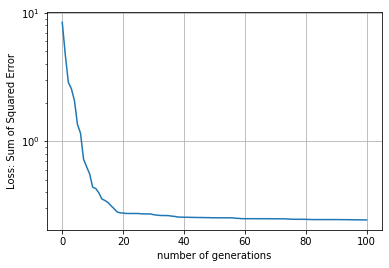

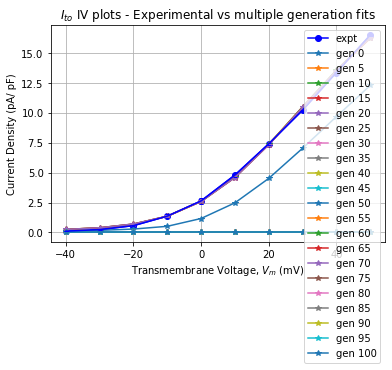

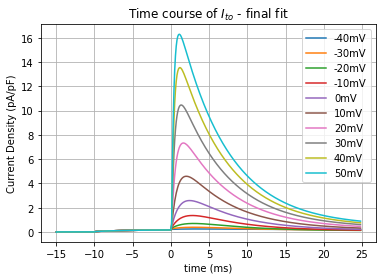

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 51, 10)    # mV, Command Voltage

# actual Y
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

# Population
# Parameter initialization
C = np.empty((200, 20))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #gtof
C[:, 1] = np.random.uniform(0, 0.1, C.shape[0])     #gtos

C[:, 2] = np.random.uniform(15.0, 25.0, C.shape[0]) #xa
C[:, 3] = np.random.uniform(8, 15, C.shape[0])     #xb
C[:, 4] = np.random.uniform(3.5, 12.5, C.shape[0])         #txaf
C[:, 5] = np.random.uniform(40, 50, C.shape[0])      #txbf
C[:, 6] = np.random.uniform(40, 60, C.shape[0])         #txcf
C[:, 7] = np.random.uniform(0, 2, C.shape[0])      #txdf
C[:, 8] = np.random.uniform(70, 95, C.shape[0])         #tyaf
C[:, 9] = np.random.uniform(30, 50, C.shape[0])       #tybf
C[:, 10] = np.random.uniform(200, 250, C.shape[0])         #tycf
C[:, 11] = np.random.uniform(5, 10, C.shape[0])          #tydf

C[:, 12] = np.random.uniform(7, 11, C.shape[0])         #txas
C[:, 13] = np.random.uniform(1, 5, C.shape[0])      #txbs
C[:, 14] = np.random.uniform(13, 17, C.shape[0])         #txcs
C[:, 15] = np.random.uniform(0, 1, C.shape[0])      #txds
C[:, 16] = np.random.uniform(750, 850, C.shape[0])         #tyas
C[:, 17] = np.random.uniform(50, 70, C.shape[0])       #tybs
C[:, 18] = np.random.uniform(8, 12, C.shape[0])         #tycs
C[:, 19] = np.random.uniform(25, 35, C.shape[0])          #tyds


##population = np.transpose(C)

Ito = np.empty((C.shape[0], len(V)))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ito[i,:], time, plt_Ito = Ito_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12],  ppln[i, 13], ppln[i, 14],
                                 ppln[i, 15], ppln[i, 16], ppln[i, 17], ppln[i, 18], ppln[i, 19])
    SSE = np.sum((Ito - Ito_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gtof
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +    #gtos
                        
                         (gene_select == 2)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 3)*np.random.uniform(-1.5, 1.5) +          #xb

                         (gene_select == 4)*np.random.uniform(-1.5, 1.5) +          #txaf
                         (gene_select == 5)*np.random.uniform(-5.0, 5.0) +      #txbf
                         (gene_select == 6)*np.random.uniform(-50.0, 50.0) +      #txcf
                         (gene_select == 7)*np.random.uniform(-2, 2) +          #txdf
                         (gene_select == 8)*np.random.uniform(-10, 10) +      #tyaf
                         (gene_select == 9)*np.random.uniform(-20, 20) +       #tybf
                         (gene_select == 10)*np.random.uniform(-50, 50) +         #tycf
                         (gene_select == 11)*np.random.uniform(-3, 3)   +   #tydf
                        
                         (gene_select == 12)*np.random.uniform(-2, 2) +          #txas
                         (gene_select == 13)*np.random.uniform(-1, 1) +      #txbs
                         (gene_select == 14)*np.random.uniform(-2, 2) +      #txcs
                         (gene_select == 15)*np.random.uniform(-0.1, 0.1) +          #txds
                         (gene_select == 16)*np.random.uniform(-10, 10) +      #tyas
                         (gene_select == 17)*np.random.uniform(-5, 5) +       #tybs
                         (gene_select == 18)*np.random.uniform(-2, 2) +         #tycs
                         (gene_select == 19)*np.random.uniform(-3, 3)        #tyds
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((10, num_of_gens))
num_mating_parents = int(C.shape[0]/5)
best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e12, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated

    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ito_fit = Ito_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9], population[b_idx, 10], population[b_idx, 11],
                              population[b_idx, 12], population[b_idx, 13], population[b_idx, 14], 
                                population[b_idx, 15],population[b_idx, 16], population[b_idx, 17],
                                 population[b_idx, 18], population[b_idx, 19])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[[best_gn_fit_idx][0][0], :])
#         plt.figure()
#         plt.plot(V, Ito_act, 'b-*', V, y_fit, '-o')
#         plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{to}$ IV plot: Experimental vrs Grandi-Pandit Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure()
#         plt.plot(time_fit, plt_Ito_fit)
#         plt.xlabel('time (ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time course of $I_{to}$')
#         plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
Itofit, time, Itofit_time  = Ito_func(Best_Sol[0],  Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
  Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7],
   Best_Sol[8],  Best_Sol[9],  Best_Sol[10],  Best_Sol[11],
   Best_Sol[12],  Best_Sol[13],  Best_Sol[14],  Best_Sol[15],
  Best_Sol[16],  Best_Sol[17],  Best_Sol[18], Best_Sol[19])
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = ItoIni_time
GA_trial_n.cur_time_fit = Itofit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = ItoIni

pickle.dump(GA_trial_n, open('Ito_GA_trial2.p', 'wb'))


print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, Ito_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
plt.show()

plt.figure()
plt.plot(time_fit, plt_Ito_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$ - final fit')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.show()


**GA 3**

generation:  0
Runtime:  0.9446535700000822 mins
fitness:  11.278855708495414
generation:  5
Runtime:  5.396554206666527 mins
fitness:  0.34580563577553636
generation:  10
Runtime:  9.859111581666609 mins
fitness:  0.1199432782467384
generation:  15
Runtime:  14.594505563333223 mins
fitness:  0.08225499289168353
generation:  20
Runtime:  19.19704502166666 mins
fitness:  0.08086222053555317
generation:  25
Runtime:  23.707024649999948 mins
fitness:  0.07904777844479911
generation:  30
Runtime:  28.221613061666723 mins
fitness:  0.07722013192355001
generation:  35
Runtime:  32.71664320000006 mins
fitness:  0.07639223120830764
generation:  40
Runtime:  37.21914738000002 mins
fitness:  0.07618391921950467
generation:  45
Runtime:  41.8001477733332 mins
fitness:  0.07602414506642716
generation:  50
Runtime:  46.33377735499986 mins
fitness:  0.07488045729556873
generation:  55
Runtime:  50.883566118333206 mins
fitness:  0.07486520207051217
generation:  60
Runtime:  55.38420356666659 mins
fit

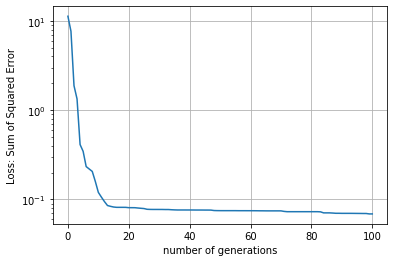

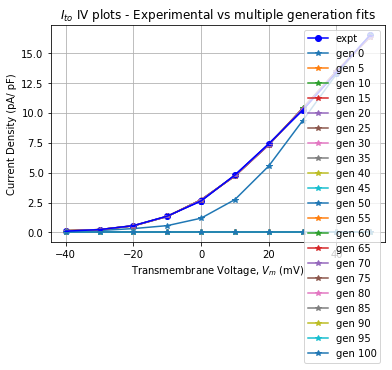

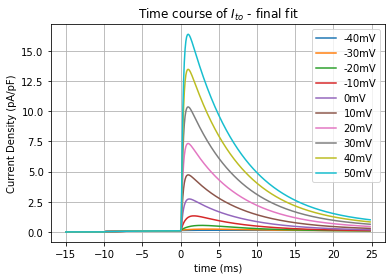

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 51, 10)    # mV, Command Voltage

# actual Y
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

# Population
# Parameter initialization
C = np.empty((200, 20))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #gtof
C[:, 1] = np.random.uniform(0, 0.1, C.shape[0])     #gtos

C[:, 2] = np.random.uniform(15.0, 25.0, C.shape[0]) #xa
C[:, 3] = np.random.uniform(8, 15, C.shape[0])     #xb
C[:, 4] = np.random.uniform(3.5, 12.5, C.shape[0])         #txaf
C[:, 5] = np.random.uniform(40, 50, C.shape[0])      #txbf
C[:, 6] = np.random.uniform(40, 60, C.shape[0])         #txcf
C[:, 7] = np.random.uniform(0, 2, C.shape[0])      #txdf
C[:, 8] = np.random.uniform(70, 95, C.shape[0])         #tyaf
C[:, 9] = np.random.uniform(30, 50, C.shape[0])       #tybf
C[:, 10] = np.random.uniform(200, 250, C.shape[0])         #tycf
C[:, 11] = np.random.uniform(5, 10, C.shape[0])          #tydf

C[:, 12] = np.random.uniform(7, 11, C.shape[0])         #txas
C[:, 13] = np.random.uniform(1, 5, C.shape[0])      #txbs
C[:, 14] = np.random.uniform(13, 17, C.shape[0])         #txcs
C[:, 15] = np.random.uniform(0, 1, C.shape[0])      #txds
C[:, 16] = np.random.uniform(750, 850, C.shape[0])         #tyas
C[:, 17] = np.random.uniform(50, 70, C.shape[0])       #tybs
C[:, 18] = np.random.uniform(8, 12, C.shape[0])         #tycs
C[:, 19] = np.random.uniform(25, 35, C.shape[0])          #tyds


##population = np.transpose(C)

Ito = np.empty((C.shape[0], len(V)))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ito[i,:], time, plt_Ito = Ito_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12],  ppln[i, 13], ppln[i, 14],
                                 ppln[i, 15], ppln[i, 16], ppln[i, 17], ppln[i, 18], ppln[i, 19])
    SSE = np.sum((Ito - Ito_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gtof
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +    #gtos
                        
                         (gene_select == 2)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 3)*np.random.uniform(-1.5, 1.5) +          #xb

                         (gene_select == 4)*np.random.uniform(-1.5, 1.5) +          #txaf
                         (gene_select == 5)*np.random.uniform(-5.0, 5.0) +      #txbf
                         (gene_select == 6)*np.random.uniform(-50.0, 50.0) +      #txcf
                         (gene_select == 7)*np.random.uniform(-2, 2) +          #txdf
                         (gene_select == 8)*np.random.uniform(-10, 10) +      #tyaf
                         (gene_select == 9)*np.random.uniform(-20, 20) +       #tybf
                         (gene_select == 10)*np.random.uniform(-50, 50) +         #tycf
                         (gene_select == 11)*np.random.uniform(-3, 3)   +   #tydf
                        
                         (gene_select == 12)*np.random.uniform(-2, 2) +          #txas
                         (gene_select == 13)*np.random.uniform(-1, 1) +      #txbs
                         (gene_select == 14)*np.random.uniform(-2, 2) +      #txcs
                         (gene_select == 15)*np.random.uniform(-0.1, 0.1) +          #txds
                         (gene_select == 16)*np.random.uniform(-10, 10) +      #tyas
                         (gene_select == 17)*np.random.uniform(-5, 5) +       #tybs
                         (gene_select == 18)*np.random.uniform(-2, 2) +         #tycs
                         (gene_select == 19)*np.random.uniform(-3, 3)        #tyds
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((10, num_of_gens))
num_mating_parents = int(C.shape[0]/5)
best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e12, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated

    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ito_fit = Ito_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9], population[b_idx, 10], population[b_idx, 11],
                              population[b_idx, 12], population[b_idx, 13], population[b_idx, 14], 
                                population[b_idx, 15],population[b_idx, 16], population[b_idx, 17],
                                 population[b_idx, 18], population[b_idx, 19])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[[best_gn_fit_idx][0][0], :])
#         plt.figure()
#         plt.plot(V, Ito_act, 'b-*', V, y_fit, '-o')
#         plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{to}$ IV plot: Experimental vrs Grandi-Pandit Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure()
#         plt.plot(time_fit, plt_Ito_fit)
#         plt.xlabel('time (ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time course of $I_{to}$')
#         plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
Itofit, time, Itofit_time  = Ito_func(Best_Sol[0],  Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
  Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7],
   Best_Sol[8],  Best_Sol[9],  Best_Sol[10],  Best_Sol[11],
   Best_Sol[12],  Best_Sol[13],  Best_Sol[14],  Best_Sol[15],
  Best_Sol[16],  Best_Sol[17],  Best_Sol[18], Best_Sol[19])
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = ItoIni_time
GA_trial_n.cur_time_fit = Itofit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = ItoIni

pickle.dump(GA_trial_n, open('Ito_GA_trial3.p', 'wb'))


print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, Ito_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
plt.show()

plt.figure()
plt.plot(time_fit, plt_Ito_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$ - final fit')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.show()


**GA 4**

generation:  0
Runtime:  0.9097103416667475 mins
fitness:  6.511809647616088
generation:  5
Runtime:  5.422333399999965 mins
fitness:  1.531874076448175
generation:  10
Runtime:  9.938594420000056 mins
fitness:  0.39712980949529053
generation:  15
Runtime:  14.54580761833325 mins
fitness:  0.23851466156675352
generation:  20
Runtime:  19.185931650000082 mins
fitness:  0.16749358037855483
generation:  25
Runtime:  23.778189436666676 mins
fitness:  0.15419063771539276
generation:  30
Runtime:  28.401938103333425 mins
fitness:  0.1512432476270907
generation:  35
Runtime:  32.99505805333344 mins
fitness:  0.1464333663132591
generation:  40
Runtime:  37.74016121500002 mins
fitness:  0.14233418887633775
generation:  45
Runtime:  42.631998533333295 mins
fitness:  0.13778558648177322
generation:  50
Runtime:  47.415044551666746 mins
fitness:  0.13641685090404984
generation:  55
Runtime:  52.06025026166656 mins
fitness:  0.13431427616426966
generation:  60
Runtime:  56.740527293333436 mins
fitn

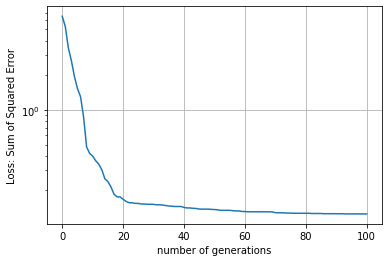

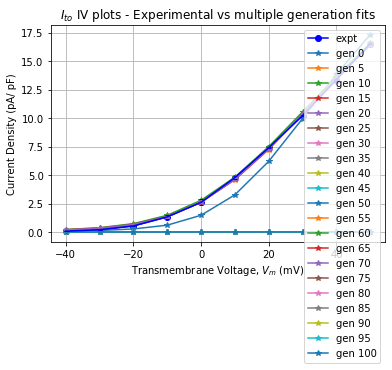

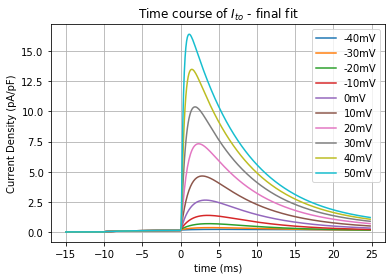

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 51, 10)    # mV, Command Voltage

# actual Y
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

# Population
# Parameter initialization
C = np.empty((200, 20))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #gtof
C[:, 1] = np.random.uniform(0, 0.1, C.shape[0])     #gtos

C[:, 2] = np.random.uniform(15.0, 25.0, C.shape[0]) #xa
C[:, 3] = np.random.uniform(8, 15, C.shape[0])     #xb
C[:, 4] = np.random.uniform(3.5, 12.5, C.shape[0])         #txaf
C[:, 5] = np.random.uniform(40, 50, C.shape[0])      #txbf
C[:, 6] = np.random.uniform(40, 60, C.shape[0])         #txcf
C[:, 7] = np.random.uniform(0, 2, C.shape[0])      #txdf
C[:, 8] = np.random.uniform(70, 95, C.shape[0])         #tyaf
C[:, 9] = np.random.uniform(30, 50, C.shape[0])       #tybf
C[:, 10] = np.random.uniform(200, 250, C.shape[0])         #tycf
C[:, 11] = np.random.uniform(5, 10, C.shape[0])          #tydf

C[:, 12] = np.random.uniform(7, 11, C.shape[0])         #txas
C[:, 13] = np.random.uniform(1, 5, C.shape[0])      #txbs
C[:, 14] = np.random.uniform(13, 17, C.shape[0])         #txcs
C[:, 15] = np.random.uniform(0, 1, C.shape[0])      #txds
C[:, 16] = np.random.uniform(750, 850, C.shape[0])         #tyas
C[:, 17] = np.random.uniform(50, 70, C.shape[0])       #tybs
C[:, 18] = np.random.uniform(8, 12, C.shape[0])         #tycs
C[:, 19] = np.random.uniform(25, 35, C.shape[0])          #tyds


##population = np.transpose(C)

Ito = np.empty((C.shape[0], len(V)))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ito[i,:], time, plt_Ito = Ito_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12],  ppln[i, 13], ppln[i, 14],
                                 ppln[i, 15], ppln[i, 16], ppln[i, 17], ppln[i, 18], ppln[i, 19])
    SSE = np.sum((Ito - Ito_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gtof
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +    #gtos
                        
                         (gene_select == 2)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 3)*np.random.uniform(-1.5, 1.5) +          #xb

                         (gene_select == 4)*np.random.uniform(-1.5, 1.5) +          #txaf
                         (gene_select == 5)*np.random.uniform(-5.0, 5.0) +      #txbf
                         (gene_select == 6)*np.random.uniform(-50.0, 50.0) +      #txcf
                         (gene_select == 7)*np.random.uniform(-2, 2) +          #txdf
                         (gene_select == 8)*np.random.uniform(-10, 10) +      #tyaf
                         (gene_select == 9)*np.random.uniform(-20, 20) +       #tybf
                         (gene_select == 10)*np.random.uniform(-50, 50) +         #tycf
                         (gene_select == 11)*np.random.uniform(-3, 3)   +   #tydf
                        
                         (gene_select == 12)*np.random.uniform(-2, 2) +          #txas
                         (gene_select == 13)*np.random.uniform(-1, 1) +      #txbs
                         (gene_select == 14)*np.random.uniform(-2, 2) +      #txcs
                         (gene_select == 15)*np.random.uniform(-0.1, 0.1) +          #txds
                         (gene_select == 16)*np.random.uniform(-10, 10) +      #tyas
                         (gene_select == 17)*np.random.uniform(-5, 5) +       #tybs
                         (gene_select == 18)*np.random.uniform(-2, 2) +         #tycs
                         (gene_select == 19)*np.random.uniform(-3, 3)        #tyds
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((10, num_of_gens))
num_mating_parents = int(C.shape[0]/5)
best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e12, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated

    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ito_fit = Ito_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9], population[b_idx, 10], population[b_idx, 11],
                              population[b_idx, 12], population[b_idx, 13], population[b_idx, 14], 
                                population[b_idx, 15],population[b_idx, 16], population[b_idx, 17],
                                 population[b_idx, 18], population[b_idx, 19])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[[best_gn_fit_idx][0][0], :])
#         plt.figure()
#         plt.plot(V, Ito_act, 'b-*', V, y_fit, '-o')
#         plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{to}$ IV plot: Experimental vrs Grandi-Pandit Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure()
#         plt.plot(time_fit, plt_Ito_fit)
#         plt.xlabel('time (ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time course of $I_{to}$')
#         plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
Itofit, time, Itofit_time  = Ito_func(Best_Sol[0],  Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
  Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7],
   Best_Sol[8],  Best_Sol[9],  Best_Sol[10],  Best_Sol[11],
   Best_Sol[12],  Best_Sol[13],  Best_Sol[14],  Best_Sol[15],
  Best_Sol[16],  Best_Sol[17],  Best_Sol[18], Best_Sol[19])
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = ItoIni_time
GA_trial_n.cur_time_fit = Itofit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = ItoIni

pickle.dump(GA_trial_n, open('Ito_GA_trial4.p', 'wb'))


print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, Ito_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
plt.show()

plt.figure()
plt.plot(time_fit, plt_Ito_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$ - final fit')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.show()


**GA 5**

generation:  0
Runtime:  0.8258860083333275 mins
fitness:  10.707294353791411
generation:  5
Runtime:  4.914436121666646 mins
fitness:  0.29139322007035473
generation:  10
Runtime:  9.070005311666652 mins
fitness:  0.19405202857611226
generation:  15
Runtime:  13.239711136666665 mins
fitness:  0.16767527344719804
generation:  20
Runtime:  17.38456020666666 mins
fitness:  0.1636844302812003
generation:  25
Runtime:  21.585708368333325 mins
fitness:  0.16078578644228553
generation:  30
Runtime:  25.829718364999977 mins
fitness:  0.15416611799917862
generation:  35
Runtime:  30.103382965000005 mins
fitness:  0.15287647480725236
generation:  40
Runtime:  34.37920860999999 mins
fitness:  0.14754916754792047
generation:  45
Runtime:  38.55274347666667 mins
fitness:  0.1425771475034955
generation:  50
Runtime:  42.75759500000001 mins
fitness:  0.13829305283830803
generation:  55
Runtime:  47.0792249383333 mins
fitness:  0.13707499283635194
generation:  60
Runtime:  51.15646430166668 mins
fitn

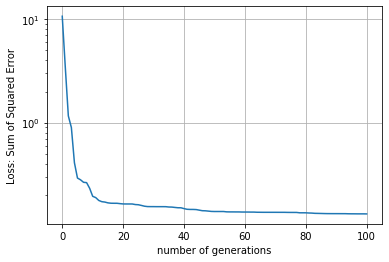

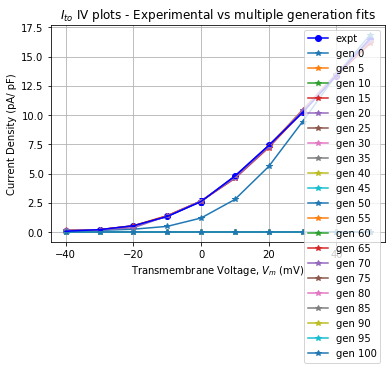

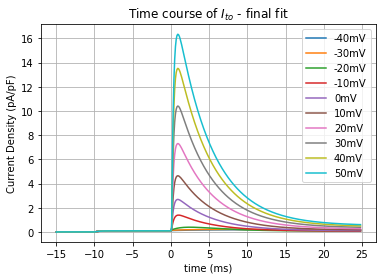

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 51, 10)    # mV, Command Voltage

# actual Y
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

# Population
# Parameter initialization
C = np.empty((200, 20))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #gtof
C[:, 1] = np.random.uniform(0, 0.1, C.shape[0])     #gtos

C[:, 2] = np.random.uniform(15.0, 25.0, C.shape[0]) #xa
C[:, 3] = np.random.uniform(8, 15, C.shape[0])     #xb
C[:, 4] = np.random.uniform(3.5, 12.5, C.shape[0])         #txaf
C[:, 5] = np.random.uniform(40, 50, C.shape[0])      #txbf
C[:, 6] = np.random.uniform(40, 60, C.shape[0])         #txcf
C[:, 7] = np.random.uniform(0, 2, C.shape[0])      #txdf
C[:, 8] = np.random.uniform(70, 95, C.shape[0])         #tyaf
C[:, 9] = np.random.uniform(30, 50, C.shape[0])       #tybf
C[:, 10] = np.random.uniform(200, 250, C.shape[0])         #tycf
C[:, 11] = np.random.uniform(5, 10, C.shape[0])          #tydf

C[:, 12] = np.random.uniform(7, 11, C.shape[0])         #txas
C[:, 13] = np.random.uniform(1, 5, C.shape[0])      #txbs
C[:, 14] = np.random.uniform(13, 17, C.shape[0])         #txcs
C[:, 15] = np.random.uniform(0, 1, C.shape[0])      #txds
C[:, 16] = np.random.uniform(750, 850, C.shape[0])         #tyas
C[:, 17] = np.random.uniform(50, 70, C.shape[0])       #tybs
C[:, 18] = np.random.uniform(8, 12, C.shape[0])         #tycs
C[:, 19] = np.random.uniform(25, 35, C.shape[0])          #tyds


##population = np.transpose(C)

Ito = np.empty((C.shape[0], len(V)))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ito[i,:], time, plt_Ito = Ito_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12],  ppln[i, 13], ppln[i, 14],
                                 ppln[i, 15], ppln[i, 16], ppln[i, 17], ppln[i, 18], ppln[i, 19])
    SSE = np.sum((Ito - Ito_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gtof
                         (gene_select == 1)*np.random.uniform(-0.01, 0.01) +    #gtos
                        
                         (gene_select == 2)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 3)*np.random.uniform(-1.5, 1.5) +          #xb

                         (gene_select == 4)*np.random.uniform(-1.5, 1.5) +          #txaf
                         (gene_select == 5)*np.random.uniform(-5.0, 5.0) +      #txbf
                         (gene_select == 6)*np.random.uniform(-50.0, 50.0) +      #txcf
                         (gene_select == 7)*np.random.uniform(-2, 2) +          #txdf
                         (gene_select == 8)*np.random.uniform(-10, 10) +      #tyaf
                         (gene_select == 9)*np.random.uniform(-20, 20) +       #tybf
                         (gene_select == 10)*np.random.uniform(-50, 50) +         #tycf
                         (gene_select == 11)*np.random.uniform(-3, 3)   +   #tydf
                        
                         (gene_select == 12)*np.random.uniform(-2, 2) +          #txas
                         (gene_select == 13)*np.random.uniform(-1, 1) +      #txbs
                         (gene_select == 14)*np.random.uniform(-2, 2) +      #txcs
                         (gene_select == 15)*np.random.uniform(-0.1, 0.1) +          #txds
                         (gene_select == 16)*np.random.uniform(-10, 10) +      #tyas
                         (gene_select == 17)*np.random.uniform(-5, 5) +       #tybs
                         (gene_select == 18)*np.random.uniform(-2, 2) +         #tycs
                         (gene_select == 19)*np.random.uniform(-3, 3)        #tyds
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 5
num_of_gens = 101
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((10, num_of_gens))
num_mating_parents = int(C.shape[0]/5)
best_gen_fitness = []
for generation in range(num_of_gens):
#     print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e12, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
#     print(best_gn_fit_idx[0].size)
#     print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
#     print(indx)
#     print(fitness[indx])
    fit_val = fitness[indx]
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
#     print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated

    if generation%gen_mod == 0:
        print('generation: ', generation)
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print('fitness: ',fit_val)
#         plt.plot(gen_num, best_gen_fitness)
#         plt.xlabel('number of generations')
#         plt.ylabel('Loss: Sum of Squared Error (log scale)')
#         plt.yscale('log')
#         plt.grid()
#         plt.show()
        y_fit, time_fit, plt_Ito_fit = Ito_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                              population[b_idx, 9], population[b_idx, 10], population[b_idx, 11],
                              population[b_idx, 12], population[b_idx, 13], population[b_idx, 14], 
                                population[b_idx, 15],population[b_idx, 16], population[b_idx, 17],
                                 population[b_idx, 18], population[b_idx, 19])
        gen_curr_arr[:, i_plt] = y_fit
#         print(population[[best_gn_fit_idx][0][0], :])
#         plt.figure()
#         plt.plot(V, Ito_act, 'b-*', V, y_fit, '-o')
#         plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
#         plt.legend(['Experimental', 'Model-fitted'], loc='best')
#         plt.xlabel('Command Voltage, Vc (mV)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('$I_{to}$ IV plot: Experimental vrs Grandi-Pandit Model fitted')
#         plt.grid()
#         plt.show()
        
#         plt.figure()
#         plt.plot(time_fit, plt_Ito_fit)
#         plt.xlabel('time (ms)')
#         plt.ylabel('Current Density (pA/pF)')
#         plt.title('Time course of $I_{to}$')
#         plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
#         plt.grid()
#         plt.show()
        i_plt = i_plt + 1

timer_stop = timeit.default_timer()        
print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
Best_Sol = population[best_match_idx[0][0], :]
final_fitness = fitness[best_match_idx[0][0]]

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
#fitted model
Itofit, time, Itofit_time  = Ito_func(Best_Sol[0],  Best_Sol[1],  Best_Sol[2],  Best_Sol[3],
  Best_Sol[4],  Best_Sol[5], Best_Sol[6],  Best_Sol[7],
   Best_Sol[8],  Best_Sol[9],  Best_Sol[10],  Best_Sol[11],
   Best_Sol[12],  Best_Sol[13],  Best_Sol[14],  Best_Sol[15],
  Best_Sol[16],  Best_Sol[17],  Best_Sol[18], Best_Sol[19])
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

#Save fitting outcomes for future plots and analysis
GA_trial_n = GA_trial()
GA_trial_n.gen_num = gen_num
GA_trial_n.loss = best_gen_fitness
GA_trial_n.final_fit_val = final_fitness
GA_trial_n.R2_sq_ini = ini_r2
GA_trial_n.R2_sq_fin = fit_r2
GA_trial_n.Parameters = Best_Sol
GA_trial_n.time = time
GA_trial_n.cur_time_ini = ItoIni_time
GA_trial_n.cur_time_fit = Itofit_time
GA_trial_n.Vcm = Vcm
GA_trial_n.I_peaks_fin = y_fit
GA_trial_n.I_peaks_ini = ItoIni

pickle.dump(GA_trial_n, open('Ito_GA_trial5.p', 'wb'))


print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

gen_num = np.arange(len(best_gen_fitness))
plt.figure()
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure()
plt.plot(V, Ito_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ito_act, yerr=Ito_err, capsize=2, color = 'blue')
plt.show()

plt.figure()
plt.plot(time_fit, plt_Ito_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{to}$ - final fit')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='best')
plt.grid()
plt.show()


Initial Model Goodness of fit, R_sq = -0.33464224925180686
GA fitted Model Goodness of fit, R_sq = 0.9995674142008156
percent change: [ 5.81569216e+03  1.69964902e+02  4.21835579e+00  2.55740323e+01
 -3.55255945e+01 -1.97959104e+01 -1.28966144e+02  4.87232470e+01
  1.26391887e+02  2.54535927e+01 -9.53331015e+01  4.47723914e+01
 -2.90731078e+00 -3.49375150e+01 -7.60306667e-01 -4.34622132e+01
 -4.95385712e+00  1.38810987e+01  1.78361590e+01 -9.06436728e+01]


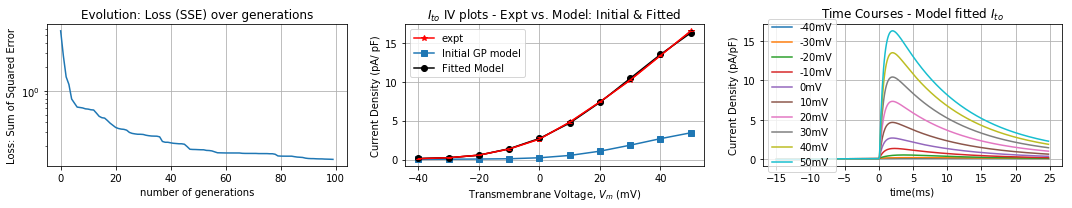

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

#initial model
ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

#fitted model
Itofit, time, Itofit_time  = Ito_func(8.28196903e-02,  1.01506803e-01,  1.98014876e+01,  1.63246242e+01,
   5.48032447e+00,  3.60918403e+01, -1.44830721e+01,  7.43616235e-01,
   1.92433104e+02,  5.01814371e+01,  1.02671768e+01,  1.01340674e+01,
   8.73834203e+00,  1.95187455e+00,  1.48859540e+01,  2.82688934e-01,
   7.60369143e+02,  6.83286592e+01,  1.17836159e+01,  2.84432346e+01)
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

ini_r2 = r2_score(Ito_act, ItoIni)
fit_r2 = r2_score(Ito_act, Itofit)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

ini_param = np.array([0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 304])
fin_param = np.array([8.28196903e-02,  1.01506803e-01,  1.98014876e+01,  1.63246242e+01,
   5.48032447e+00,  3.60918403e+01, -1.44830721e+01,  7.43616235e-01,
   1.92433104e+02,  5.01814371e+01,  1.02671768e+01,  1.01340674e+01,
   8.73834203e+00,  1.95187455e+00,  1.48859540e+01,  2.82688934e-01,
   7.60369143e+02,  6.83286592e+01,  1.17836159e+01,  2.84432346e+01])
percent_change = ((fin_param - ini_param)/ini_param)*100

print('percent change:', percent_change)

plt.figure(figsize=(15,3))
plt.subplot(1,3,3)
plt.plot(time, Itofit_time)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Courses - Model fitted $I_{to}$')
plt.legend(['-40mV', '-30mV', '-20mV', '-10mV', '0mV', '10mV', '20mV', '30mV', '40mV', '50mV'], loc='center left')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Vcm, Ito_act, 'r-*', label = 'expt') #experimental plot
plt.plot(Vcm, ItoIni, '-s', label='Initial GP model')  #initial model plot
plt.plot(Vcm, Itofit, 'k-o', label='Fitted Model') #modelfitted
plt.errorbar(Vcm, Ito_act, yerr=Ito_err, capsize=2, color = 'red') #errorbar experimental data
plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{to}$ IV plots - Expt vs. Model: Initial & Fitted')
plt.grid()
plt.legend(loc='best')

plt.subplot(1,3,1)
gen_num = np.arange(len(best_gen_fitness))
plt.plot(gen_num[:100], best_gen_fitness[:100])
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.title('Evolution: Loss (SSE) over generations')
plt.grid()
plt.tight_layout()
plt.show()


In [1]:
# Creating a class to hold the trials data
import pickle

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    

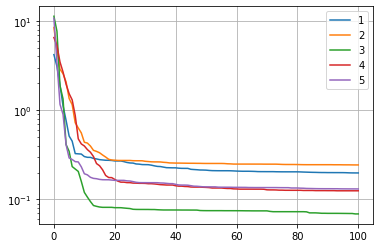

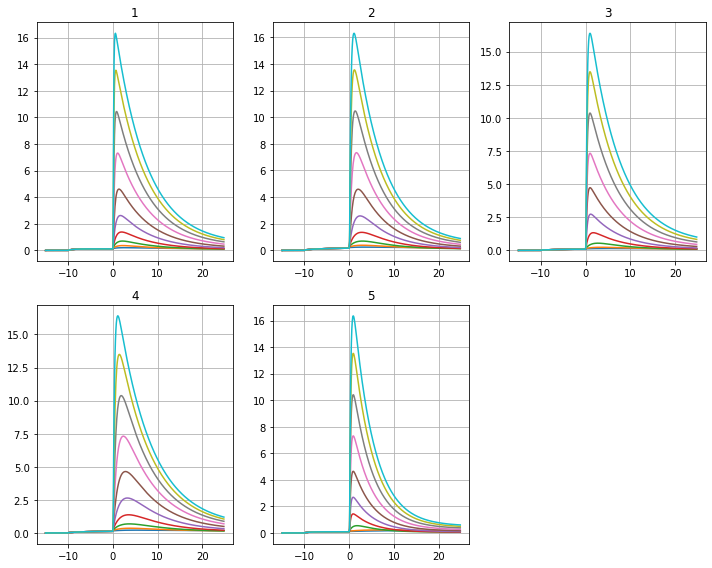

R_sq fit:  
[1] 0.9993740576262252 
[2] 0.9992306818592483 
[3] 0.9997831818096632 
[4] 0.9996048377179467 
[5] 0.9995856414434366

final_fitness:  
[1] 0.19798585206441885 
[2] 0.24333567112062107 
[3] 0.06857969032839671 
[4] 0.12499000609949518 
[5] 0.13106179629066445


In [3]:
import pickle
import matplotlib.pyplot as plt

GA1 = pickle.load(open('Ito_GA_trial1.p', 'rb'))
GA2 = pickle.load(open('Ito_GA_trial2.p', 'rb'))
GA3 = pickle.load(open('Ito_GA_trial3.p', 'rb'))
GA4 = pickle.load(open('Ito_GA_trial4.p', 'rb'))
GA5 = pickle.load(open('Ito_GA_trial5.p', 'rb'))
plt.plot(GA1.gen_num, GA1.loss, label = '1')
plt.plot(GA2.gen_num, GA2.loss, label = '2')
plt.plot(GA3.gen_num, GA3.loss, label = '3')
plt.plot(GA4.gen_num, GA4.loss, label = '4')
plt.plot(GA5.gen_num, GA5.loss, label = '5')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize = (10,8))
plt.subplot(2,3,1)
plt.plot(GA1.time, GA1.cur_time_fit, label='1')
plt.title('1')
plt.grid()
plt.subplot(2,3,2)
plt.plot(GA2.time, GA2.cur_time_fit, label='2')
plt.title('2')
plt.grid()
plt.subplot(2,3,3)
plt.plot(GA3.time, GA3.cur_time_fit, label='3')
plt.title('3')
plt.grid()
plt.subplot(2,3,4)
plt.plot(GA4.time, GA4.cur_time_fit, label='4')
plt.title('4')
plt.grid()
plt.subplot(2,3,5)
plt.plot(GA5.time, GA5.cur_time_fit, label='5')
plt.title('5')
plt.grid()

plt.tight_layout()
plt.show()

print('R_sq fit: ', '\n[1]', GA1.R2_sq_fin, '\n[2]', GA2.R2_sq_fin, '\n[3]', GA3.R2_sq_fin, '\n[4]', GA4.R2_sq_fin, '\n[5]', GA5.R2_sq_fin)

print('\nfinal_fitness: ', '\n[1]', GA1.final_fit_val, '\n[2]', GA2.final_fit_val, '\n[3]', GA3.final_fit_val, '\n[4]', GA4.final_fit_val, '\n[5]', GA5.final_fit_val)

In [5]:
import numpy as np
Ito_trials_r2 = np.array([GA1.R2_sq_fin, GA2.R2_sq_fin, GA3.R2_sq_fin, GA4.R2_sq_fin, GA5.R2_sq_fin])
Ito_trials_fit = np.array([GA1.final_fit_val, GA2.final_fit_val, GA3.final_fit_val, GA4.final_fit_val, GA5.final_fit_val])

mean_r2 = np.mean(Ito_trials_r2)
stdv_r2 = np.std(Ito_trials_r2)

mean_fit = np.mean(Ito_trials_fit)
stdv_fit = np.std(Ito_trials_fit)

print('mean r2: ', mean_r2)
print('stdv r2: ', stdv_r2)
print('\n')

print('mean loss: ', mean_fit)
print('stdv loss: ', stdv_fit)

mean r2:  0.9995156800913041
stdv r2:  0.00019270794347703909


mean loss:  0.15319060318071925
stdv loss:  0.060953608490819156


mean:  [ 0.19737028  0.30886149  0.60324014  1.36650311  2.65336537  4.64212739
  7.32045317 10.40973614 13.51852843 16.35237345]
stdv:  [0.03378582 0.07276872 0.12121644 0.02165208 0.05047045 0.04735111
 0.00812132 0.03745912 0.02932725 0.03776127]


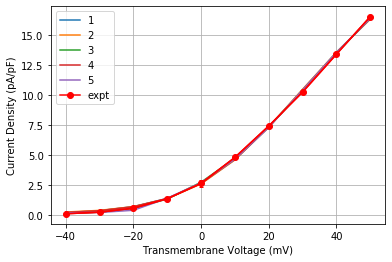

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ItoIni, time, ItoIni_time = Ito_func(0.0014, 0.0376, 19, 13, 8.5, 45, 50, 0.5, 85, 40, 220, 7, 9, 3, 15, 0.5, 800, 60, 10, 30)

# #fitted model
# Itofit, time, Itofit_time  = Ito_func(8.28196903e-02,  1.01506803e-01,  1.98014876e+01,  1.63246242e+01,
#    5.48032447e+00,  3.60918403e+01, -1.44830721e+01,  7.43616235e-01,
#    1.92433104e+02,  5.01814371e+01,  1.02671768e+01,  1.01340674e+01,
#    8.73834203e+00,  1.95187455e+00,  1.48859540e+01,  2.82688934e-01,
#    7.60369143e+02,  6.83286592e+01,  1.17836159e+01,  2.84432346e+01)
Ito_act = np.array(
    [0.099409446, 0.231767945, 0.562416217, 1.356413635, 2.633327121, 4.797965012, 7.412658668, 10.23024459,
     13.38482092, 16.51873419])
Ito_err = np.array([0.011391257, 0.006720079, 0.026371109, 0.152178369, 0.262996531, 0.14855301, 0.058495101,
                    0.036813974, 0.030923715, 0.038889919])

Vcm = np.arange(-40, 51, 10)

plt.plot(GA1.Vcm, GA1.I_peaks_fin, label='1')
plt.plot(GA2.Vcm, GA2.I_peaks_fin, label='2')
plt.plot(GA3.Vcm, GA3.I_peaks_fin, label='3')
plt.plot(GA4.Vcm, GA4.I_peaks_fin, label='4')
plt.plot(GA5.Vcm, GA5.I_peaks_fin, label='5')
plt.plot(Vcm, Ito_act, 'r-o', label='expt')
plt.errorbar(Vcm, Ito_act, yerr=Ito_err, capsize=2, color = 'red')
plt.xlabel('Transmembrane Voltage (mV)')
plt.ylabel('Current Density (pA/pF)')
plt.grid()
plt.legend()

Ito_GA_IV = np.zeros((5,len(GA1.I_peaks_fin)))
Ito_GA_IV[0,:] = GA1.I_peaks_fin
Ito_GA_IV[1,:] = GA2.I_peaks_fin
Ito_GA_IV[2,:] = GA3.I_peaks_fin
Ito_GA_IV[3,:] = GA4.I_peaks_fin
Ito_GA_IV[4,:] = GA5.I_peaks_fin


Ito_mean = np.mean(Ito_GA_IV, axis=0)
Ito_stdv = np.std(Ito_GA_IV, axis=0)
#print(If_GA_IV)
print('mean: ',Ito_mean)
print('stdv: ',Ito_stdv)

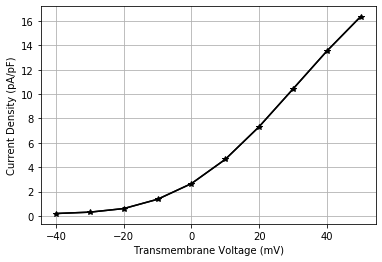

In [9]:
# plt.figure(figsize=(10,8))
#plt.plot(Vcm, If_act, 'r-o', label='expt')
#plt.errorbar(Vcm, If_act, yerr=If_err, capsize=2, color = 'red')
plt.plot(Vcm, Ito_mean, 'k-*', label = 'Model(mean)')
plt.errorbar(Vcm, Ito_mean, yerr=Ito_stdv, capsize=2, color = 'black')
plt.grid()
plt.xlabel('Transmembrane Voltage (mV)')
plt.ylabel('Current Density (pA/pF)')
plt.show()

In [6]:
loss_ini = np.array([GA1.loss[0], GA2.loss[0], GA3.loss[0], GA4.loss[0], GA5.loss[0]])
loss_ini_mean = np.mean(loss_ini)
loss_ini_stdv = np.std(loss_ini)

print('initial losses: ', loss_ini)
print('mean initial loss: ', loss_ini_mean)
print('std initial loss: ', loss_ini_stdv)

initial losses:  [ 4.19125879  8.44358433 11.27885571  6.51180965 10.70729435]
mean initial loss:  8.226560565819366
std initial loss:  2.635969506930538


In [7]:
loss_fin = np.array([GA1.loss[-1], GA2.loss[-1], GA3.loss[-1], GA4.loss[-1], GA5.loss[-1]])
loss_fin_mean = np.mean(loss_fin)
loss_fin_stdv = np.std(loss_fin)

print('initial losses: ', loss_fin)
print('mean initial loss: ', loss_fin_mean)
print('std initial loss: ', loss_fin_stdv)

initial losses:  [0.19805252 0.24353602 0.068836   0.12499001 0.13106454]
mean initial loss:  0.15329581847567414
std initial loss:  0.060951399265165185
